<a href="https://colab.research.google.com/github/SidharthBhakth/Spam-Classification/blob/master/Spam_classification_with_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam classification with LSTMs

In [0]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalMaxPooling1D
from tensorflow.keras.models import Model

In [2]:
# Get data from github
!wget -nc https://raw.githubusercontent.com/SidharthBhakth/Spam-Classification/master/spam.csv

--2020-05-21 03:51:28--  https://raw.githubusercontent.com/SidharthBhakth/Spam-Classification/master/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.04s   

2020-05-21 03:51:28 (13.5 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
# Load data as pandas dataframe
df = pd.read_csv('spam.csv', encoding = "CP437")

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
# Drop unnecessary columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [5]:
# Rename columns
df.columns = ['labels', 'data']

df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
# Create binary labels
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})

y = df['b_labels'].values

In [0]:
class_names = ['ham', 'spam']

In [0]:
# Split the data to train and test datasets
df_train, df_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.3)

In [0]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)

sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [10]:
# Get word to index mapping
word2idx = tokenizer.word_index

# Size of vocabulary
V = max(word2idx.values())

print('Unique tokens: {}'.format(V))

Unique tokens: 7342


In [11]:
# Pad sequences
X_train = pad_sequences(sequences_train)
print('Shape of train data tensor: {}'.format(X_train.shape)) # N x T array

# Get sequence length
T = X_train.shape[1]

X_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of test data tensor: {}'.format(X_test.shape)) # N x T array

Shape of train data tensor: (3900, 162)
Shape of test data tensor: (1672, 162)


In [12]:
# Build the model

# Embedding dimensionality
D = 20

"""
The size of the embedding layer is (V+1) x D since the first index starts from 1 and not 0
Thus, the final index of the embedding matrix is V, so we have the size V+1
"""

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(units=15, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

#  Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=2)

Epoch 1/10
122/122 - 4s - loss: 0.4980 - accuracy: 0.8400 - val_loss: 0.3407 - val_accuracy: 0.8762
Epoch 2/10
122/122 - 4s - loss: 0.3110 - accuracy: 0.8615 - val_loss: 0.2433 - val_accuracy: 0.8762
Epoch 3/10
122/122 - 4s - loss: 0.1971 - accuracy: 0.9031 - val_loss: 0.1558 - val_accuracy: 0.9803
Epoch 4/10
122/122 - 4s - loss: 0.1231 - accuracy: 0.9908 - val_loss: 0.1127 - val_accuracy: 0.9856
Epoch 5/10
122/122 - 4s - loss: 0.0846 - accuracy: 0.9954 - val_loss: 0.0967 - val_accuracy: 0.9844
Epoch 6/10
122/122 - 3s - loss: 0.0637 - accuracy: 0.9967 - val_loss: 0.0804 - val_accuracy: 0.9880
Epoch 7/10
122/122 - 4s - loss: 0.0507 - accuracy: 0.9979 - val_loss: 0.0751 - val_accuracy: 0.9868
Epoch 8/10
122/122 - 4s - loss: 0.0423 - accuracy: 0.9982 - val_loss: 0.0692 - val_accuracy: 0.9868
Epoch 9/10
122/122 - 4s - loss: 0.0341 - accuracy: 0.9990 - val_loss: 0.0657 - val_accuracy: 0.9868
Epoch 10/10
122/122 - 4s - loss: 0.0288 - accuracy: 0.9992 - val_loss: 0.0586 - val_accuracy: 0.9862

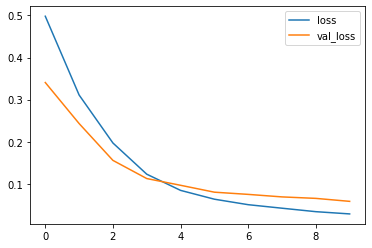

In [13]:
# Plot loss per epoch
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

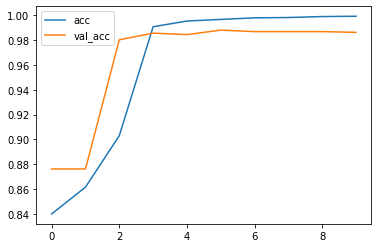

In [14]:
# Plot accuracy per epcch
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [0]:
# Predict
y_pred = model.predict(X_test).flatten()
y_pred = (y_pred > 0.5).astype(int)

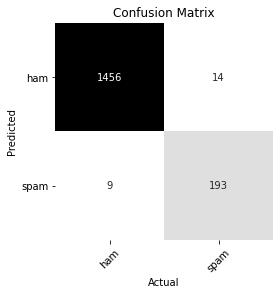

In [16]:
# Plot annotated confusion matrix
cnf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()

fig = sns.heatmap(cnf_mat.T, square=True, annot=True, fmt='d', cmap='binary', cbar=False)

plt.xlabel('Actual')
ax.set_xticklabels(class_names, rotation=45)

plt.ylabel('Predicted')
ax.set_yticklabels(class_names, rotation=0)

plt.title('Confusion Matrix')

plt.show()

In [17]:
# Misclassified example
misclassified_idx = np.where(y_pred != y_test)[0]
idx = np.random.choice(misclassified_idx)

print("Actual: {}".format(class_names[y_test[idx]]))
print("Predicted: {}".format(class_names[y_pred[idx]]))
print("\n")
print(df_test.iloc[idx])

Actual: ham
Predicted: spam


Will purchase d stuff today and mail to you. Do you have a po box number?
